In [40]:
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

#df = pd.read_csv("sentiment140-subset.csv", nrows=100000)
df = pd.read_csv('vaccination_all_tweets.csv')
#df = df.drop(index=90) #this tweet's formatting is just really messed up
df.head(10)
df_train = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])
df_train = df_train.drop(index=90) #this tweet's formatting is just really messed up
df_train.head(10)

In [42]:
df_train['polarity'] = df_train['polarity'].replace(4,1)
y = df_train['polarity'].values

array([0, 0, 0, ..., 1, 1, 1])

In [20]:
import re
import string
import unidecode

def word_count(words):
    return len(words.split())

def remove_punct(s):
    punct = string.punctuation + 'Ã§º¯³|¡¿'
    for char in punct:
        s = s.replace(char, '')
    return s

def remove_accents(accented_string):
    unaccented_string = unidecode.unidecode(accented_string)
    return unaccented_string

def clean(df):
    df['text'] = df['text'].map(lambda x:re.sub(r'\w*@\w*', '', x) ) #remove twitter handles
    df['text'] = df['text'].map(lambda x:re.sub(r'http\S+', '', x) ) #remove urls
    df['text'] = df['text'].map(lambda x:re.sub(r'[0-9]', '', x) ) #remove numbers
    df['text'] = df['text'].map(lambda x:remove_punct(x)) #remove punctuation marks
    df['text'] = df['text'].map(lambda x:remove_accents(x)) #remove accents
    df['text'] = df['text'].map(lambda x: x.lower()) #lower case

clean(df)
clean(df_train)

In [5]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vidursinha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vidursinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vidursinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
        if len(w)>1:
            word = wordLemm.lemmatize(w)
            finalwords.append(word)
    return ' '.join(finalwords)

In [21]:
df['text'] = df['text'].apply(lambda x: process_tweets(x))
df_train['text'] = df_train['text'].apply(lambda x: process_tweets(x))

In [8]:
df.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,folk said daikon paste could treat cytokine st...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,world wrong side history year hopefully bigges...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,coronavirus sputnikv astrazeneca pfizerbiontec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,fact immutable senator even youre ethically st...,NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain need vaccine whereareallthesickpeople ...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,anyone useful adviceguidance whether covid vac...,NaN,Twitter for iPhone,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,bit sad claim fame success vaccination patriot...,['vaccination'],Twitter Web App,0,4,False
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,many bright day best bidenharris winning elect...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False
8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,covid vaccine getting covidvaccine covid pfize...,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",Twitter Web App,2,1,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,covidvaccine state start getting covidvaccine ...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False


In [30]:
X = df['text'].values
X_train = df_train['text'].values
print(len(X))
print(len(X_train))
type(X)

69718
1599999


numpy.ndarray

In [32]:
total = np.concatenate((X, X_train), axis=None)
vector = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
total_vectorized = vector.fit_transform(total)

In [38]:
X_test = total_vectorized[:69718,:]
X_train = total_vectorized[69718:,:]
print(X_test.shape)
print(X_train.shape)

(69718, 4619975)
(1599999, 4619975)


In [43]:
from sklearn.model_selection import cross_val_score
lr_xval_model = LogisticRegression(random_state=3, solver='liblinear', verbose=True)
lr_xval_scores = cross_val_score(lr_xval_model, X_train, y, cv=4)
lr_xval_scores.mean()

[LibLinear][LibLinear][LibLinear][LibLinear]

0.7919404963012409

In [44]:
log_reg_model = LogisticRegression(random_state=3, solver='liblinear', verbose=True)
log_reg_model.fit(X_train, y)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='liblinear', tol=0.0001, verbose=True,
                   warm_start=False)

In [45]:
covid_sent_pred = log_reg_model.predict(X_test)

In [56]:
covid_sent_pred[344]

0

In [61]:
X[3441]

'careful people life depends twentythree people died norway within day receiving first ...'

In [62]:
df['text'][3441]

'Be careful , people lives depends on it as Twenty-three people died in Norway within days of receiving their first… https://t.co/JjhnqVoolS'

In [66]:
import datetime
date_time_obj = datetime.datetime.strptime(df['date'][0], '%Y-%m-%d %H:%M:%S')

In [65]:
df['date'][0]

'2020-12-20 06:06:44'

In [164]:
def get_two_week_indexes(month, first_half):
    indexes = []
    for i in range(len(df)):
        date_time = datetime.datetime.strptime(df['date'][i], '%Y-%m-%d %H:%M:%S')
        if date_time.month == month:
            if first_half:
                if date_time.day < 16:
                    indexes.append(i)
            else:
                if date_time.day >= 16:
                    indexes.append(i)
    return indexes

In [263]:
def get_keyword_indexes(word):
    ret_list = []
    for i in range(len(X)):
        if word in X[i]:
            ret_list.append(i)
    return ret_list

def get_positive_percentage(indexes):
    pred_vals = 0
    count = 0
    for i in indexes:
        pred_vals += covid_sent_pred[i]
        count += 1
    if count == 0:
        return 0
    return pred_vals/count
        

In [154]:
side_effect_idx = get_keyword_indexes("side effect") + get_keyword_indexes("side affect")

In [279]:
pos_percentage = []
for i in [12,1,2,3,4]:
    pos_percentage.append(get_positive_percentage(get_two_week_indexes(i, True)))
    pos_percentage.append(get_positive_percentage(get_two_week_indexes(i, False)))

Text(0.5, 1.0, 'All Tweets Sentiments Over Time')

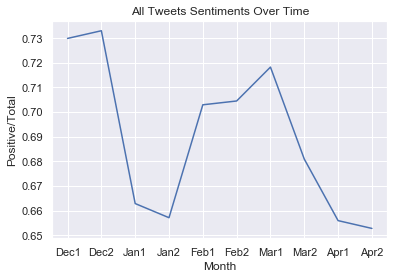

In [280]:
months_axis = ["Dec1", "Dec2", "Jan1", "Jan2", "Feb1", "Feb2", "Mar1", "Mar2", "Apr1", "Apr2"]
time_plot_dict = {'Month': months_axis, 'Positive/Total': pos_percentage}
time_plot_df = pd.DataFrame(time_plot_dict)

# plot using lineplot
sns.set(style='darkgrid')
sns.lineplot(x='Month', y='Positive/Total', data=time_plot_df, sort=False)
plt.title("All Tweets Sentiments Over Time")

In [281]:
vaccines = ['moderna', 'pfizer', 'johnson']
vaccine_percent_pos = []
for vaccine in vaccines:
    vaccine_percent_pos.append(get_positive_percentage(get_keyword_indexes(vaccine)))

Text(0.5, 1.0, 'US Vaccine Comparison')

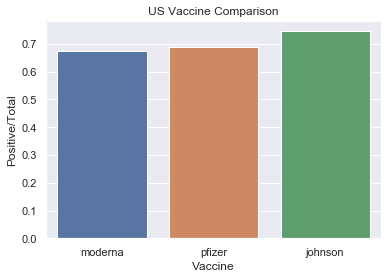

In [282]:
vaccine_plot_dict = {'Vaccine': vaccines, 'Positive/Total': vaccine_percent_pos}
vaccine_plot_df = pd.DataFrame(vaccine_plot_dict)
sns.barplot(x="Vaccine", y="Positive/Total", data=vaccine_plot_df)
plt.title("US Vaccine Comparison")

In [283]:
vaccine_side_effect_percent_pos = []
for vaccine in vaccines:
    idx_list = list(set(get_keyword_indexes(vaccine)) & set(get_keyword_indexes("side effect")))
    vaccine_side_effect_percent_pos.append(get_positive_percentage(idx_list))

Text(0.5, 1.0, 'US Vaccine Side Effects Comparison')

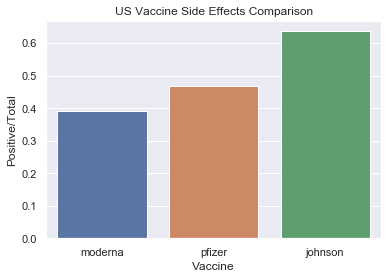

In [284]:
vaccine_side_effect_plot_dict = {'Vaccine': vaccines, 'Positive/Total': vaccine_side_effect_percent_pos}
vaccine_side_effect_plot_df = pd.DataFrame(vaccine_side_effect_plot_dict)
sns.barplot(x="Vaccine", y="Positive/Total", data=vaccine_side_effect_plot_df)
plt.title("US Vaccine Side Effects Comparison")

In [285]:
vaccine_time_values = {
    'pfizer' : [],
    'moderna' : [],
    'johnson' : [],
}
for i in [12,1,2,3,4]:
    for vaccine in vaccines:
        idx_list_1 = list(set(get_keyword_indexes(vaccine)) & set(get_two_week_indexes(i, True)))
        idx_list_2 = list(set(get_keyword_indexes(vaccine)) & set(get_two_week_indexes(i, False)))
        vaccine_time_values[vaccine].append(get_positive_percentage(idx_list_1))
        vaccine_time_values[vaccine].append(get_positive_percentage(idx_list_2))

Text(0.5, 1.0, 'US Vaccines Over Time')

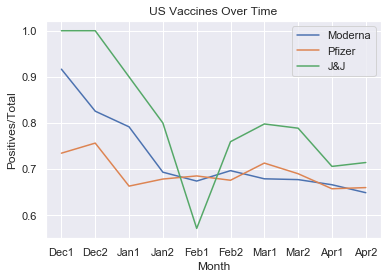

In [286]:
vaccine_time_values["Month"] = months_axis
vaccine_time_plot_df = pd.DataFrame(vaccine_time_values)
sns.set(style='darkgrid')
sns.lineplot(x='Month', y = 'moderna', data=vaccine_time_plot_df, sort=False)
sns.lineplot(x='Month', y = 'pfizer', data=vaccine_time_plot_df, sort=False)
sns.lineplot(x='Month', y = 'johnson', data=vaccine_time_plot_df, sort=False)
plt.legend(labels=['Moderna', 'Pfizer', 'J&J'])
plt.ylabel("Positives/Total")
plt.title("US Vaccines Over Time")

In [235]:
np.savetxt("covid_tweet_predictions.csv", covid_sent_pred, delimiter=",", header="Sentiments")

In [231]:
len(covid_sent_pred)

69718

In [252]:
read_test = pd.read_csv('covid_tweet_predictions.csv')
sentiments = read_test['# Sentiments']

In [254]:
sentiments[0]

1.0

Text(0.5, 1.0, 'European Vaccine Comparison')

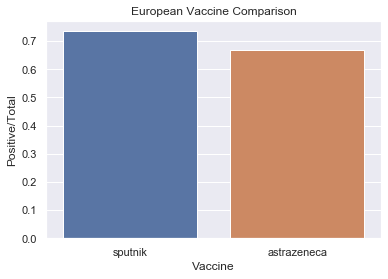

In [298]:
euro_vaccines = ['sputnik', 'astrazeneca']
euro_vaccine_percent_pos = []
for euro_vaccine in euro_vaccines:
    euro_vaccine_percent_pos.append(get_positive_percentage(get_keyword_indexes(euro_vaccine)))
euro_vaccine_plot_dict = {'Vaccine': euro_vaccines, 'Positive/Total': euro_vaccine_percent_pos}
euro_vaccine_plot_df = pd.DataFrame(euro_vaccine_plot_dict)
sns.barplot(x="Vaccine", y="Positive/Total", data=euro_vaccine_plot_df)
plt.title("European Vaccine Comparison")

Text(0.5, 1.0, 'India Vaccine Comparison')

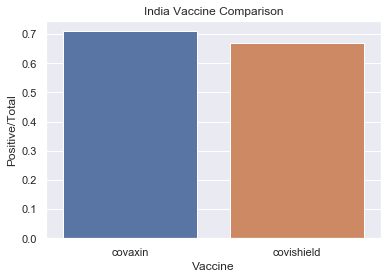

In [277]:
indian_vaccines = ['covaxin', 'covishield']
indian_vaccine_percent_pos = []
for indian_vaccine in indian_vaccines:
    indian_vaccine_percent_pos.append(get_positive_percentage(get_keyword_indexes(indian_vaccine)))
indian_vaccine_plot_dict = {'Vaccine': indian_vaccines, 'Positive/Total': indian_vaccine_percent_pos}
indian_vaccine_plot_df = pd.DataFrame(indian_vaccine_plot_dict)
sns.barplot(x="Vaccine", y="Positive/Total", data=indian_vaccine_plot_df)
plt.title("India Vaccine Comparison")

Text(0.5, 1.0, 'India Vaccines Over Time')

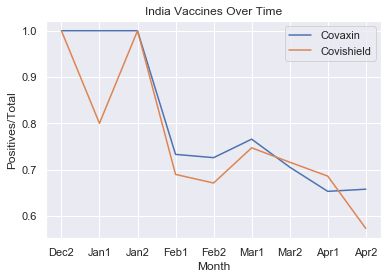

In [275]:
vaccine_time_values = {
    'covaxin' : [],
    'covishield' : [],
}
for i in [12,1,2,3,4]:
    for vaccine in indian_vaccines:
        idx_list_1 = list(set(get_keyword_indexes(vaccine)) & set(get_two_week_indexes(i, True)))
        idx_list_2 = list(set(get_keyword_indexes(vaccine)) & set(get_two_week_indexes(i, False)))
        vaccine_time_values[vaccine].append(get_positive_percentage(idx_list_1))
        vaccine_time_values[vaccine].append(get_positive_percentage(idx_list_2))
vaccine_time_values['covaxin'].pop(0)
vaccine_time_values['covishield'].pop(0)
months_axis_india = ["Dec2", "Jan1", "Jan2", "Feb1", "Feb2", "Mar1", "Mar2", "Apr1", "Apr2"]
vaccine_time_values["Month"] = months_axis_india
vaccine_time_plot_df = pd.DataFrame(vaccine_time_values)
sns.set(style='darkgrid')
sns.lineplot(x='Month', y = 'covaxin', data=vaccine_time_plot_df, sort=False)
sns.lineplot(x='Month', y = 'covishield', data=vaccine_time_plot_df, sort=False)
plt.legend(labels=['Covaxin', 'Covishield'])
plt.ylabel("Positives/Total")
plt.title("India Vaccines Over Time")

Text(0.5, 1.0, 'Pfizer/Moderna Dose Comparison')

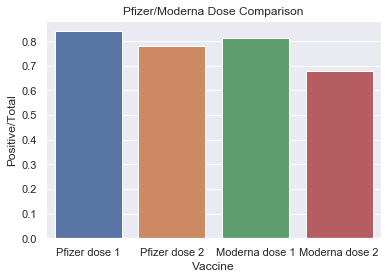

In [276]:
vaccine_doses = []
for vaccine in ['pfizer', 'moderna']:
    idx_list1 = list(set(get_keyword_indexes(vaccine)) & set(get_keyword_indexes("first dose")))
    idx_list2 = list(set(get_keyword_indexes(vaccine)) & set(get_keyword_indexes("second dose")))
    vaccine_doses.append(get_positive_percentage(idx_list1))
    vaccine_doses.append(get_positive_percentage(idx_list2))
vaccine_doses_dict = {'Vaccine': ['Pfizer dose 1', 'Pfizer dose 2', 'Moderna dose 1', 'Moderna dose 2'], 'Positive/Total': vaccine_doses}
vaccine_doses_df = pd.DataFrame(vaccine_doses_dict)
sns.barplot(x="Vaccine", y="Positive/Total", data=vaccine_doses_df)
plt.title("Pfizer/Moderna Dose Comparison")

In [287]:
from numpy import random

x=random.randint(len(df), size=(20))
for i in x:
    if covid_sent_pred[i] == 0:
        print("Tweet: ", X[i], "Prediction: Negative")
    else:
        print("Tweet: ", X[i], "Prediction: Positive")
    print("\n")

Tweet:  none dirty chinese communist party cpc vaccine recognized worldwide approved far ... Prediction: Negative


Tweet:  good news pfizer moderna covid vaccine prove effective realworld study realworldstudy ... Prediction: Positive


Tweet:  sinovac ceo caught bribing china 's drug regulator approval sinopharm side effect unsaf ... Prediction: Positive


Tweet:  nepal becomes third country give emergency nod indian vaccine covaxin nepal ... Prediction: Negative


Tweet:  also bb update ... Prediction: Positive


Tweet:  iran khamenei 's red crescent announced ban import pfizerbiontech vaccinesth ... Prediction: Negative


Tweet:  dos china donated sinopharm covid vaccine departed beijing earlier today ... Prediction: Positive


Tweet:  anyone interested hearing positive side effect pfizerbiontech vaccine pain 'm sure ... Prediction: Positive


Tweet:  somalia another african country receive chinesemade covid vaccine china donate dos ... Prediction: Positive


Tweet:  im pfizerprince

Text(0.5, 1.0, 'European Vaccines Over Time')

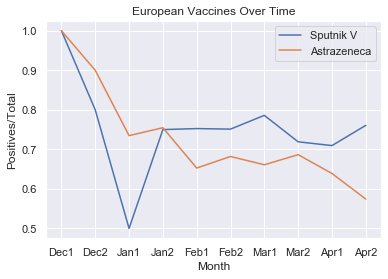

In [301]:
#vaccine_time_values = {
#    'sputnik' : [],
#    'astrazeneca' : [],
#}
#for i in [12,1,2,3,4]:
#    for vaccine in euro_vaccines:
#        idx_list_1 = list(set(get_keyword_indexes(vaccine)) & set(get_two_week_indexes(i, True)))
#        idx_list_2 = list(set(get_keyword_indexes(vaccine)) & set(get_two_week_indexes(i, False)))
#        vaccine_time_values[vaccine].append(get_positive_percentage(idx_list_1))
#        vaccine_time_values[vaccine].append(get_positive_percentage(idx_list_2))
#vaccine_time_values['covaxin'].pop(0)
#vaccine_time_values['covishield'].pop(0)
#months_axis_india = ["Dec2", "Jan1", "Jan2", "Feb1", "Feb2", "Mar1", "Mar2", "Apr1", "Apr2"]
vaccine_time_values["Month"] = months_axis
vaccine_time_plot_df = pd.DataFrame(vaccine_time_values)
sns.set(style='darkgrid')
sns.lineplot(x='Month', y = 'sputnik', data=vaccine_time_plot_df, sort=False)
sns.lineplot(x='Month', y = 'astrazeneca', data=vaccine_time_plot_df, sort=False)
plt.legend(labels=['Sputnik V', 'Astrazeneca'])
plt.ylabel("Positives/Total")
plt.title("European Vaccines Over Time")

In [295]:
vaccine_time_values

{'sputnik v': [],
 'astrazeneca': [],
 'Month': ['Dec1',
  'Dec2',
  'Jan1',
  'Jan2',
  'Feb1',
  'Feb2',
  'Mar1',
  'Mar2',
  'Apr1',
  'Apr2']}

In [296]:
euro_vaccines

['sputnik v', 'astrazeneca']